## Installing libraries


In [1]:
!pip install timm==0.6.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 30.6 MB/s eta 0:00:00


## Clone ZoeDepth and yolov5 github repository

In [2]:
!git clone https://github.com/isl-org/ZoeDepth.git
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'ZoeDepth'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 111 (delta 24), reused 13 (delta 13), pack-reused 77
Receiving objects: 100% (111/111), 4.10 MiB | 18.83 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Cloning into 'yolov5'...
remote: Enumerating objects: 15814, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 15814 (delta 9), reused 22 (delta 2), pack-reused 15769
Receiving objects: 100% (15814/15814), 14.59 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (10823/10823), done.


## Import libraries

In [3]:
from PIL import Image
import torch
import os
%matplotlib inline
import matplotlib.pyplot as plt
# from IPython.core.display import Image
from glob import glob
from os import path
import numpy as np
import cv2
%cd /content/ZoeDepth
from zoedepth.utils.misc import get_image_from_url, colorize
%cd /content/

/content/ZoeDepth
/content


## Connecting to google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Sanity checks, to make sure everything is working

In [5]:
!python /content/ZoeDepth/sanity.py

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or help(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use help(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
******************** Testing zoedepth ********************
Config:
{'attractor_alpha': 1000,
 'attractor_gamma': 2,
 'attractor_kind': 'mean',
 'attractor_type': 'inv',
 'aug': True,
 'bin_centers_type': 'softplus',
 'bin_embedding_dim': 128,
 'clip_gr

## Load the ZoeDepth model

In [6]:
%cd ZoeDepth
zoe = torch.hub.load(".", "ZoeD_NK", source="local", pretrained=True)
zoe = zoe.to('cuda')
%cd /content/

/content/ZoeDepth
img_size [384, 512]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt


Downloading: "https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt" to /root/.cache/torch/hub/checkpoints/ZoeD_M12_NK.pt
100%|██████████| 1.35G/1.35G [01:31<00:00, 15.8MB/s]


Loaded successfully
/content


## let's make a small depth estimation :)


In [44]:
def depth_estimation_from_image(image_path, display_or_nor = True):
  img = Image.open(image_path)
  out = img.rotate(180) # rotating
  depth = zoe.infer_pil(out)
  colored_depth = colorize(depth) # 4 channels
  if display_or_nor:
    fig, axs = plt.subplots(1,2, figsize=(15,7))
    for ax, im, title in zip(axs, [out, depth], ['Input', 'Predicted Depth Map']):
      ax.imshow(im)
      ax.axis('off')
      ax.set_title(title)
    plt.show()
  return out, depth

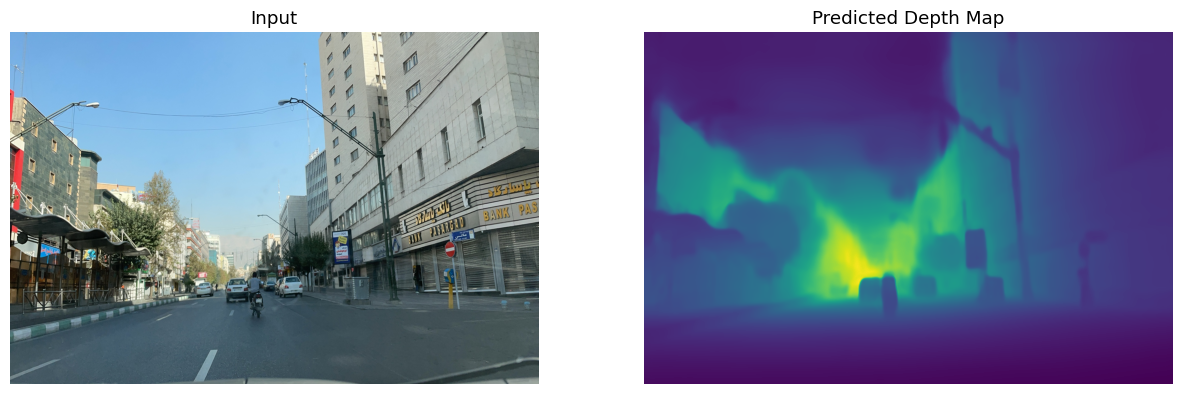

In [45]:
%matplotlib inline

out,depth_map = depth_estimation_from_image('/content/drive/MyDrive/data/train/images/35.jpg')

In [9]:
from numpy import savetxt
# save shape to csv file
savetxt('depth9.csv', depth_map, delimiter=' ')

In [10]:
depth_map.shape

(1280, 1920)

## Load the YOLOv5s model

In [11]:
# Model
import locale
locale.getpreferredencoding = lambda: "UTF-8"
%cd yolov5
!pip install -r requirements.txt
%cd /content/
detection_model = torch.hub.load("ultralytics/yolov5",'custom', path= '/content/drive/MyDrive/best-final.pt')  # or yolov5n - yolov5x6, custom

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.5/627.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
/content


/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-7-10 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 206 layers, 12342868 parameters, 0 gradients, 16.2 GFLOPs
Adding AutoShape... 



## let's do a small object detection :)



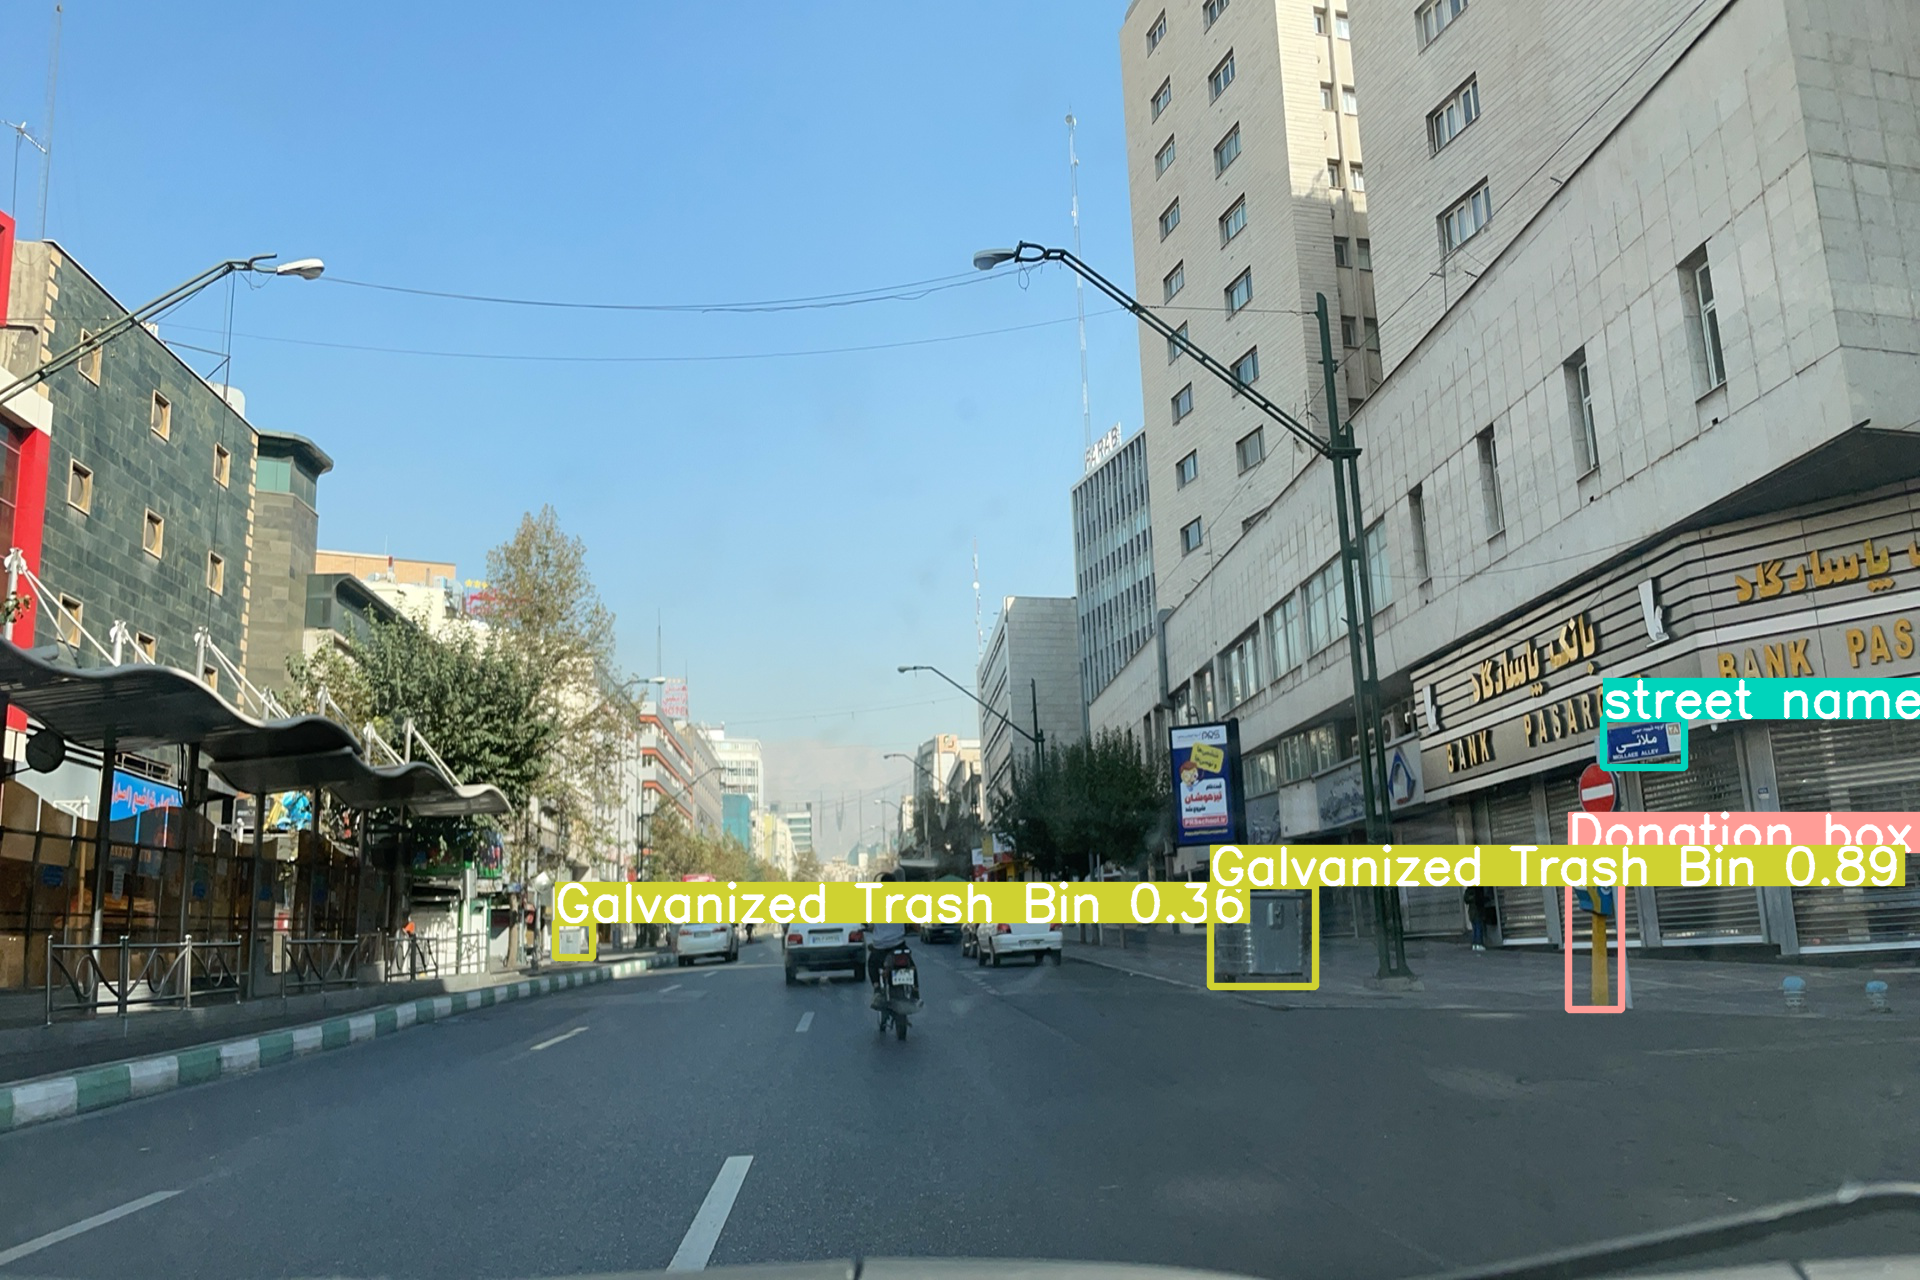

Saved 1 image to /content/drive/MyDrive/tmp-smple2
Saved results to /content/drive/MyDrive/tmp-smple2



In [12]:
# Images
img_test_object_detection = "/content/drive/MyDrive/data/train/images/35.jpg"  # or file, Path, PIL, OpenCV, numpy, list

# Inference
results = detection_model(img_test_object_detection)

# Results
results.show()  # or .show(), .save(), .crop(), .pandas(), etc.
crops = results.crop(save=True, save_dir='/content/drive/MyDrive/tmp-smple') # this way we can save cropped bounding boxes for each inference
df = results.pandas()

In [13]:
temp_result= df.xyxy[0]

In [14]:
temp_result

,xmin,ymin,xmax,ymax,confidence,class,name
0,1210.433350,885.390015,1315.490479,986.934814,0.890546,4,Galvanized Trash Bin
1,1568.021118,852.745789,1621.259399,1009.229004,0.852172,1,Donation box
2,1603.756836,718.531250,1684.142090,767.890076,0.721095,9,street name sign
3,555.404785,922.440796,592.179443,957.278198,0.359833,4,Galvanized Trash Bin


In [24]:
temp_result.to_csv('/content/drive/My Drive/detection_results_csv/smlpe.csv', index=False) # saves the detection result to google drive

## now let's mix it all

In [28]:
def project_depth_to_points(calib, depth, max_high):
    rows, cols = depth.shape # depth.shape= (1280, 1920)
    c, r = np.meshgrid(np.arange(cols), np.arange(rows)) # c-->x , r-->y (in pixel coordination)
    # c= (1280, 1920)
    # r= (1280, 1920)
    points = np.stack([c, r, depth]) # z is depth in metric,  points.shape= (3, 1280, 1920)
    points = points.reshape((3, -1))
    points = points.T  # points= (2457600, 3)
    # points are like:
    # [[          0           0      12.945]
    # [          1           0       12.97]
    # [          2           0      12.988]
    # ...
    # [       1917        1279      7.9683]
    # [       1918        1279      7.9673]
    # [       1919        1279      7.9661]]
    cloud = calib.project_image_to_pointcloud(points)

    return cloud

class Calibration(object):
    """
      At least one of "intrinsics_matrix" or "from_kitti_path" should not be None
      There is two option for initialize a calibration object:
        1) Pass intrinsics_matrix in form of
            [f^2_u,   0,      c^2_u,
              0,      f^2_v,  c^2_v
              0,      0,      1]

        2) Set "from_kitti_path": path to kitti standard calibration file (.txt)
    """
    def __init__(self, intrinsics_matrix=None, from_kitti_path=None):
      if from_kitti_path is not None:
        calibs = self.read_calib_file(from_kitti_path)
        # Projection matrix from rect camera coord to image2 coord
        self.P = calibs['P2']
        self.P = np.reshape(self.P, [3,4])
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs['R0_rect']
        self.R0 = np.reshape(self.R0,[3,3])
      elif intrinsics_matrix is not None:
        self.P = np.array(intrinsics_matrix)
        self.R0 = None

      # Camera intrinsics and extrinsics
      self.c_u = self.P[0,2]
      self.c_v = self.P[1,2]
      self.f_u = self.P[0,0]
      self.f_v = self.P[1,1]
      if from_kitti_path is not None:
        self.b_x = self.P[0,3]/(-self.f_u) # relative
        self.b_y = self.P[1,3]/(-self.f_v)
      else:
        self.b_x = None
        self.b_y = None


    def read_calib_file(self, filepath):
        ''' Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        '''
        data = {}
        with open(filepath, 'r') as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line)==0: continue
                key, value = line.split(':', 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass

        return data


    # ===========================
    # ------- 2d to 3d ----------
    # ===========================
    def project_image_to_rect(self, uv_depth):
        ''' Input: nx3 first two channels are uv, 3rd channel
                   is depth in rect camera coord.
            Output: nx3 points in rect camera coord.
        '''
        # uv_depth.shape = (2457600, 3)
        n = uv_depth.shape[0]

        x = ((uv_depth[:,0]-self.c_u)*uv_depth[:,2])/self.f_u
        y = ((uv_depth[:,1]-self.c_v)*uv_depth[:,2])/self.f_v

        if self.b_x is not None:
          x += self.b_x
          y += self.b_y

        pts_3d_rect = np.zeros((n,3))
        pts_3d_rect[:,0] = x
        pts_3d_rect[:,1] = y
        pts_3d_rect[:,2] = uv_depth[:,2]
        return pts_3d_rect

    def project_image_to_pointcloud(self, uv_depth):
        pts_3d_rect = self.project_image_to_rect(uv_depth)
        if self.R0 is not None:
          return np.transpose(np.dot(np.linalg.inv(self.R0), np.transpose(pts_3d_rect)))
        return pts_3d_rect

In [30]:
intrinsics_matrix = [[1.41546024e+03, 0.00000000e+00, 9.64916262e+02],
[0.00000000e+00, 1.67670492e+03, 6.06212729e+02],
[0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]

calib = Calibration(intrinsics_matrix=intrinsics_matrix)

In [29]:
# print(project_depth_to_points(calib, depth_map ,1000)[749][1643])
project_depth_to_points(calib, depth_map ,1000)

array([[    -8.8245,     -4.6802,      12.945],
       [    -8.8322,     -4.6892,       12.97],
       [    -8.8358,      -4.696,      12.988],
       ...,
       [     5.3597,      3.1973,      7.9683],
       [     5.3647,      3.1969,      7.9673],
       [     5.3695,      3.1965,      7.9661]])

In [31]:
print(project_depth_to_points(calib, depth_map ,1000).shape) # first 1280, is first col in image

(2457600, 3)


In [81]:
w = 1920
h = 1280
from google.colab.patches import cv2_imshow
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('/content/drive/MyDrive/video1.mp4', fourcc, 7, (w,2*h)) # result video
images_path= '/content/drive/MyDrive/final_dataset_merged/images'
final_output = [ str(i)+".jpg" for i in sorted([ int(num.split('/')[-1].split('.')[0]) for num in os.listdir(images_path)])]

for filename in final_output:
  out, depth = depth_estimation_from_image(os.path.join(images_path, filename), False) # depth estimation, depth.shape = (1280, 1920)
  pc = project_depth_to_points(calib, depth, 1000000) # pc is coordination of each pixel in camera coordination system
  # pc[0] is x y z of pixel 0,0 in camera coordinate system
  # pc[1] is x y z of pixel 1,0 in camera coordinate system
  dist = np.sqrt(pc[:,0]**2 + pc[:,2]**2) # this is distance of camera to each pixel not depth sqrt(x^2 + z^2)
  # dist.shape = (2457600,)
  results = detection_model(os.path.join(images_path, filename)) # object detection
  df = results.pandas().xyxy[0]
  df[['xmin','ymin','ymax','xmax']] = df[['xmin','ymin','ymax','xmax']].astype(int)
  img = cv2.imread(os.path.join(images_path, filename)) # img.shape = (1280, 1920, 3)
  dist= dist.reshape(img.shape[:2]) # img.shape[:2] = (1280, 1920)
  df['metric_depth'] = '0'
  df['ref-img'] = os.path.join(images_path, filename)
  for index,row in df.iterrows():
    xmin,ymin,xmax,ymax,cls = row['xmin'], row['ymin'], row['xmax'], row['ymax'], row['name']
    cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    dep = np.median(dist[ymin:ymax,xmin:xmax])  # the calculated depth for an object is median between its bounding box's pixels
    df.at[index,'metric_depth'] = np.mean(depth[ymin:ymax,xmin:xmax])
    cv2.putText(img,cls + ' ' + str(round(dep,1)) + ' m',(xmax,ymax),0,1,(0,255,0))
  dist = cv2.merge((dist,dist,dist))
  backtorgb = cv2.cvtColor(depth,cv2.COLOR_GRAY2RGB)
  normalized_matrix = cv2.normalize(backtorgb, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  color_map = cv2.applyColorMap(normalized_matrix, cv2.COLORMAP_BONE)
  cv2.imwrite('temp.png', color_map)
  tmpimg = cv2.imread('temp.png')
  img1 = cv2.vconcat([tmpimg, img])
  video.write(img1)
  num = filename.split('.')[0]
  df.to_csv('/content/drive/MyDrive/detection_results_csv'+'/'+num+'.csv', index=False) # saves the detection result to google drive
cv2.destroyAllWindows()
video.release()